In [1]:
import seaborn as sns
sns.set()

# Decision Trees and Random Forests

## Decision Trees


A decision tree is a binary tree.  At each of the internal nodes, it chooses a feature $i$ and a threshold $t$.  Each leaf has a value.  Evaluation of the model is just traversal of the tree from the root.  At each node, we go down the left branch if $X_{ji} \le t$ and the right branch otherwise.  The value of the model $f(X_{ji})$ is the value at the terminating leaf of this traversal.

### Decision Tree Classifier


Below, we show a picture of this on small decision tree trained on the iris data set.  Notice that each internal node has a decision criterion and each leaf has the breakdown of label classes left at this leaf of the tree.  For a geometric picture of a decision tree, take a look at this [blog post](https://shapeofdata.wordpress.com/2013/07/02/decision-trees/).

In [2]:
# Train and draw out a decision tree

from IPython import display
from sklearn import datasets, tree, utils
from dmba import plotDecisionTree

# target (y) has 3 classes, 50 observations each
iris = datasets.load_iris()
print(iris['DESCR'])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

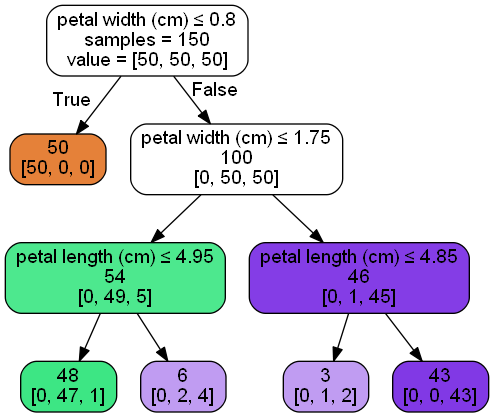

In [16]:
# Train a small decision tree on the iris data set
X_iris, y_iris = utils.shuffle(iris.data, iris.target, random_state=42)
tree_clf = tree.DecisionTreeClassifier(max_depth=3).fit(X_iris, y_iris)

plotDecisionTree(tree_clf, feature_names=iris.feature_names)

The goal is to find a tree where with "pure leaves." In other words, we want observations of a single class to end up in a given leaf. We optimize machine learning models by minimizing some error function with respect to our model parameters. For classification trees, we can formalize the purity criterion by using the **Gini index** or **Gini impurity**, defined as follows: 

$$ G_m = \sum_k p_{mk} (1 - p_{mk})\, , $$

where $p_{mk}$ is the fraction of training observations in region $m$ from class $k$. As an example consider data consisting of 2 classes of 50 observations each. Now consider two classifiers -- the first is a decision tree that perfectly separates your observations by class into two leaves while the second places 25 observations of each class into two leaves. How do the Gini indices of (one leaf in) these two trees compare?

1. Case 1: value = [50, 0]
$$ G = \frac{50}{50} \left(1 - \frac{50}{50}\right) + \frac{0}{50} \left(1 - \frac{0}{50}\right) = 0 $$

1. Case 2: value = [25, 25]
$$ G = \frac{25}{50} \left(1 - \frac{25}{50}\right) + \frac{25}{50} \left(1 - \frac{25}{50}\right) = 0.5 $$

The Gini index is quite similar to the entropy

$$ H_m = - \sum_k p_{mk} \log_2 p_{mk} $$

1. Case 1: value = [50, 0]
$$ H = -\left[\frac{50}{50} \log_2 \left(\frac{50}{50}\right) + \frac{0}{50} \log_2 \left(\frac{0}{50}\right)\right] = 0 $$

1. Case 2: value = [25, 25]
$$ H = -\left[\frac{25}{50} \log_2 \left(\frac{25}{50}\right) + \frac{25}{50} \log_2 \left(\frac{25}{50}\right)\right] = 1 $$

Both the Gini index and the entropy are minimized by *pure* nodes&mdash;those that contain only a single class. Sometimes the __Information Gain__ is used instead. Information gain is the difference in entropy of the unsplit data set to the entropy of the data after the split. 

$$ IG = H - \sum_m \rho_m H_m $$

where $\rho_m$ is the fraction of elements in region $m$ compared to the whole data set. If we use information gain as a metric, we wish to maximize it.

In practice, we are searching for the optimal splitting thresholds that minimize these costs.

### Decision Tree Regressor


Let's revisit the California housing data set and model home prices with a decision tree regressor.

In [4]:
# Train a basic decision tree.  Can you do better?
from sklearn import model_selection
import pandas as pd

california = datasets.fetch_california_housing()
print(california['DESCR'])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

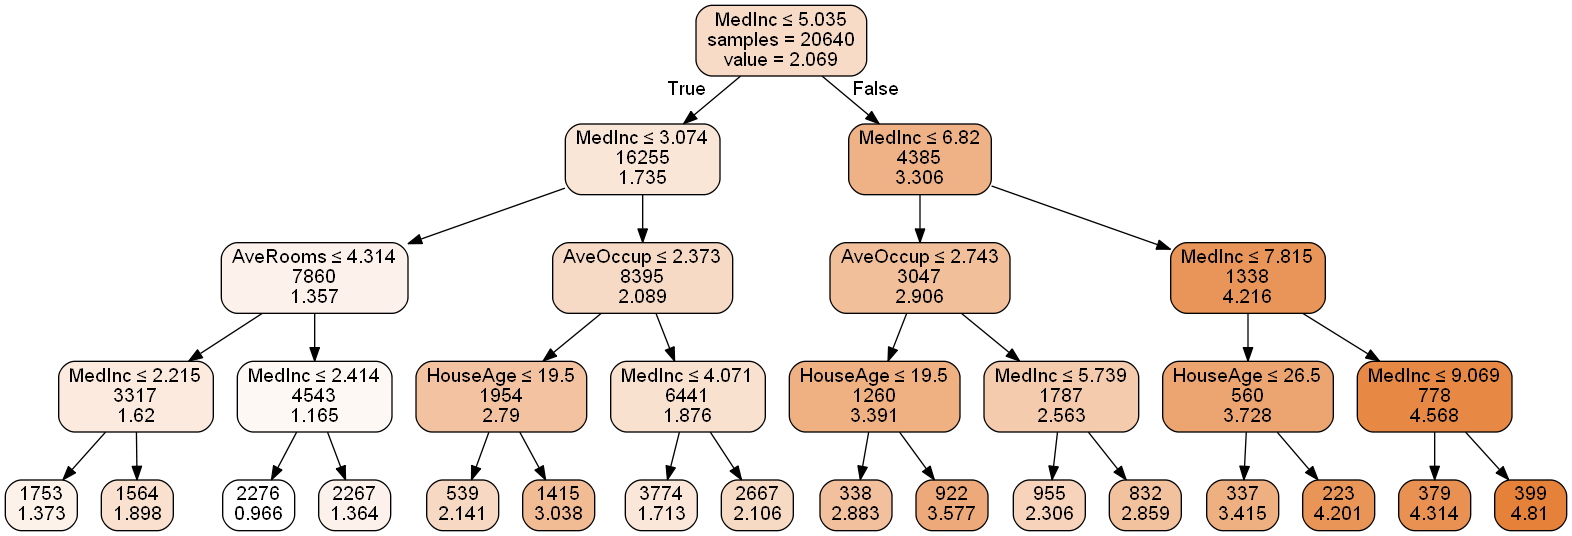

In [21]:
# Train a small decision tree on the iris data set
X_cal, y_cal = utils.shuffle(california.data, california.target, random_state=42)
tree_reg = tree.DecisionTreeRegressor(max_depth=4).fit(X_cal, y_cal)

plotDecisionTree(tree_reg, feature_names=california.feature_names)

Regression trees typically minimize the mean squared error. Notice in the figure above that the "values" associated with each node are no longer vectors containing information on number of observations associated with each class. Instead the values are scalars. The MSE of each node is computed by comparing the values of the observations (or samples) in that node to the value of the node itself. 

### Optimization Algorithm and Tree Building


How do we optimize these values to split on? There are a bunch of algorithms to [choose from](http://www.math.le.ac.uk/people/ag153/homepage/SofeikovTyuMirGorProchIJCNN2014.pdf), but we will consider the simple [Iterative Dichotomiser 3 (ID3)](https://en.wikipedia.org/wiki/ID3_algorithm) for classification. We will iterate through each feature and recursively find the split which maximizes our information gain (or minimizes some cost) for each subset of data. The procedure is as follows:

1. For a set of values $x_j$ (for a given feature $j$), generate a set of evenly spaced threshold values {$t_{j1},...,t_{jK}$} that span the range of $x_j$. 
1. For each threshold value $t_{jk}$, compute the information gain associated with a split at this value.
1. Find the threshold that results in the maximum information gain, $t_{jM}$
1. Repeat the previous two steps for every unused attribute and select the attribute (and associated threshold) with the largest information gain. 
1. Split the data into $x_j < t_{jM}$ and $x_j \ge t_{jM}$. 
1. Remove $t_{jM}$ from {$t_{j1},...,t_{jK}$}.
1. Repeat the process on each subset until some condition is met. 

Stopping conditions include the following:
1. The observations are grouped into pure subsets. 
1. There are no more attributes left.
1. A condition set by the hyperparameters (below) is met.

### Hyperparameters 


The architecture of decision trees can be controlled by many hyperparameters (see Sklearn's [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) for details). The decision tree classifier and regressor share all of the same hyperparameters except for one -- there is a "class_weight" option for the classifier in the event you have unbalanced classes. (See the Unbalanced Classes notebook for information.) We have listed four major ones with their descriptions below:

<table>
<tr>
<th style="text-align: left">Feature</th>
<th style="text-align: left">Value</th>
</tr>

<tr>
<td style="text-align: left"><code>max_features</code></td>
<td style="text-align: left">The number of features to consider when choosing a split for an internal node</td>
</tr>

<tr>
<td style="text-align: left"><code>max_depth</code></td>
<td style="text-align: left">The maximum depth of tree from the root</td>
</tr>

<tr>
<td style="text-align: left"><code>min_samples_split</code></td>
<td style="text-align: left">Minimum number of samples required for a split to be considered</td>
</tr>

<tr>
<td style="text-align: left"><code>min_samples_leaf</code></td>
<td style="text-align: left">Minimum number of samples required for each leaf</td>
</tr>
</table>

Play around with different values for different hyperparameters in the cell below, to get a feel for what they do.

**Question**: How do each of these features affect the Variance Bias Decomposition?

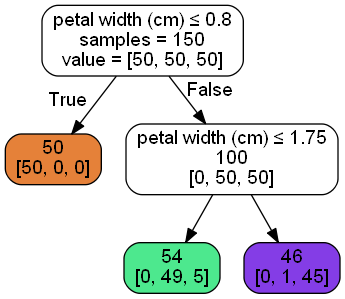

In [26]:
tree_clf = tree.DecisionTreeClassifier(min_samples_leaf=30).fit(X_iris, y_iris)

# Generate a plot of the decision tree
plotDecisionTree(tree_clf, feature_names=iris.feature_names)

## Ensemble Methods

### Random Forests


A random forest is just an ensemble of decision trees.  The predicted value is just the average of the trees (for both regression and classification problems -- for classification problems, it is the probabilities that are averaged).  You can adjust `n_estimators` to change the number of trees in the forest.  Random forests demonstrate the idea of bootstrap aggregation, or **bagging**. Each individual model has an equal vote in the ensemble, and you have the freedom to skew the weak learners towards higher variance, knowing that the averaging will (ideally) wash out the randomness and prevent overfitting.

If each tree is trained on the same subset of data, why aren't they identical?  Two reasons:
1. **Subsampling**: each tree is actually trained on a random selected (with replacement) subset (i.e. bootstrap)
1. **Maximum Features**: the optimal split comes from a randomly selected subset of the features.  In Scikit-learn, this feature is controlled by `max_features`.

If you take a look at the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), you'll notice that while random forests share many hyperparameters in common with decision trees, random forests have a few more:

<table>
<tr>
<th style="text-align: left">Feature</th>
<th style="text-align: left">Value</th>
</tr>

<tr>
<td style="text-align: left"><code>n_estimators</code></td>
<td style="text-align: left">The number of trees in the forest.</td>
</tr>

<tr>
<td style="text-align: left"><code>bootstrap</code></td>
<td style="text-align: left">Whether bootstrap samples are used when building trees.</td>
</tr>

<tr>
<td style="text-align: left"><code>oob_score</code></td>
<td style="text-align: left">Whether to use out-of-bag samples to estimate the generalization accuracy.</td>
</tr>

<tr>
<td style="text-align: left"><code>n_jobs</code></td>
<td style="text-align: left">The number of jobs to run in parallel for both fit and predict. If -1, then the number of jobs is set to the number of cores.</td>
</tr>

<tr>
<td style="text-align: left"><code>warm_start</code></td>
<td style="text-align: left">When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest.</td>
</tr>
</table>

Notice how their construction can be parallelized by setting the parameter `n_jobs`.

### Extremely Random Forests


As described Sklearn's [documentation](http://scikit-learn.org/stable/modules/ensemble.html) for ensemble methods:

>In extremely randomized trees (see `ExtraTreesClassifier` and `ExtraTreesRegressor` classes), randomness goes one step further in the way splits are computed. As in random forests, a random subset of candidate features is used, but instead of looking for the most discriminative thresholds, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule. This usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias.

**Question**: What happens to bias and variance of the individual trees in the averaging process of Random Forests and Extremely Random Forests.  How would you change your parameters to compensate?

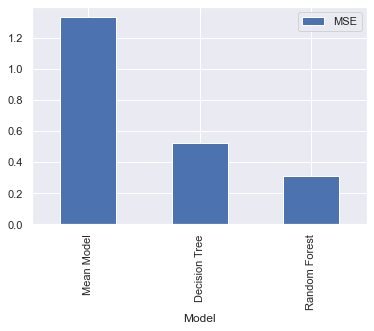

In [28]:
# Train random forests with default parameters.  Can you do better?
from sklearn import model_selection, ensemble
import pandas as pd

cv = model_selection.ShuffleSplit(n_splits=20, test_size=0.2, random_state=42)
def compute_error(clf, X, y):
    return - model_selection.cross_val_score(clf, X, y, cv=cv, scoring='neg_mean_squared_error').mean()

tree_reg = tree.DecisionTreeRegressor()
# extra_reg = ensemble.ExtraTreesRegressor(n_estimators=50)
forest_reg = ensemble.RandomForestRegressor(n_estimators=50)

model_performance = pd.DataFrame([
    ("Mean Model", y_cal.var()),
    ("Decision Tree", compute_error(tree_reg, X_cal, y_cal)),
    ("Random Forest", compute_error(forest_reg, X_cal, y_cal)),
#    ("Extra Random Forest", compute_error(extra_reg, X_cal, y_cal)),
], columns=["Model", "MSE"])
model_performance.plot(x="Model", y="MSE", kind="bar");

### Gradient Boosting Trees


Gradient Boosting algorithms train a sequence of models and combine them to make sophisticated (low bias) predictions. The key idea is that we can iteratively reduce any loss function using a strategy that imitates gradient descent.

The combined model can be written as

$$ f(X) = f_m(X) = \sum_{k=1}^m \gamma_k h_k(x) $$

where $h_k$ are **weak learners**.  For Gradient Boosting Trees, the $h_k$ are stump trees (very short trees, often with a single split). At each iteration, we want to add a new term to the sum that reduces the loss function. First, we train a weak learner $h_m$ to fit the **pseudo-residuals**

$$r_m = - \left[\frac{\partial L(y_{true},y_{pred})}{\partial y_{pred}} \right]_{y_{pred} = f_{m-1}(X)}     $$

and then we do a linear search to find the coefficient $\gamma_m$ that minimizes

$$ L(y_{true},f_{m-1}(X) + \gamma_m h_m(X)) .$$

The intuition is that $r_m$ represents the direction in which we would like to modify our predictions to decrease the loss function most quickly. $h_m(X)$ represents a step that's roughly in the same direction, although there will be some error because of how simple the weak learners are. (by design, otherwise the algorithm would overfit) It's not obvious how big of a step we should take in the $h_m(X)$ direction, so we do a search to find the best coefficient. Then we set

$$ f_m(x) = f_{m-1}(x) + \gamma_m h_m(x) $$

as our new predictor and iterate. 

We can give a more concrete description when the loss function is mean squared error. In this case, the pseudo-residuals are residuals in the usual sense (times a constant), so the training target for each new term is just the prediction error of the previous stage of the model. As you can see in the following demo, we gradually build a complicated model by iteratively compensating for the error in the previous stage.  

In [8]:
from matplotlib import pylab as plt
from ipywidgets import interact
import numpy as np
sns.set(font_scale=1.5)

# Generate test data
rng = np.random.RandomState(42)
N_points = 400
X = np.sort(5 * rng.rand(N_points, 1), axis=0)
y = np.sin(X).ravel() + .4 * (0.5 - rng.rand(N_points))

# Regular array of X values for plotting
X_reg = np.linspace(0,5,50)    

# Helper code to plot data and predictions
def make_subplot(y,y_pred,color,title,label):
    plt.plot(X, y, 'b.')
    plt.plot(X_reg,y_pred,c=color,label=label)
    plt.ylim(-1.3,1.3)
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()

# Fit/plot gradient boosting model and next term
def make_plot(n_estimators=1):    
    est = ensemble.GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=1, max_depth=1)
    est.fit(X,y)
    y_pred = est.predict(X_reg.reshape(-1,1))
    
    residuals = y - est.predict(X.reshape(-1,1))
    res_est = tree.DecisionTreeRegressor(max_depth=1)
    y_res = res_est.fit(X.reshape(-1,1),residuals).predict(X_reg.reshape(-1,1))  
    
    fig, ax = plt.subplots()
    fig.set_size_inches(20, 8)
    plt.subplot(1, 2, 1)
    make_subplot(y,y_pred,"red","Original Data","Boosting Model")
    plt.subplot(1, 2, 2)
    make_subplot(residuals,y_res,"green","Residuals","Next Term")

interact(make_plot, n_estimators=(1,25));

interactive(children=(IntSlider(value=1, description='n_estimators', max=25, min=1), Output()), _dom_classes=(…

There are a few basic variants that are usually applied

1.  **Learning Rate**: we usually reduce the learning rate $\alpha$ by choosing a value $0 < \alpha < 1$ such that

    $$ f_m(x) = f_{m-1}(x) + \alpha \gamma_m h_m(x) $$

    Setting $\alpha = 1$ would yield the model present above.  This slows down the rate at which we learn.
1.  **Subsampling**: we can learn on a fraction of the data which is a subsample of the full data set.
1.  **Max Features**: we can learn from only a subset of the features (i.e. trees only select a subset of the features).
1.  **Trying out different loss functions**: We can choose different functional forms $L$.

Beware of overfitting here. You can learn more about gradient boosting [here](http://scikit-learn.org/stable/modules/ensemble.html) and [here](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/).

**Question**: How do these techniques affect the bias and variance of the learned models?

In [9]:
# GradientBoostingRegressor
gradient_reg = ensemble.GradientBoostingRegressor()

gradient_performance = pd.DataFrame([
    ("Gradient Boosted Regressor", compute_error(gradient_reg, X_cal, y_cal))
], columns=["Model", "MSE"])

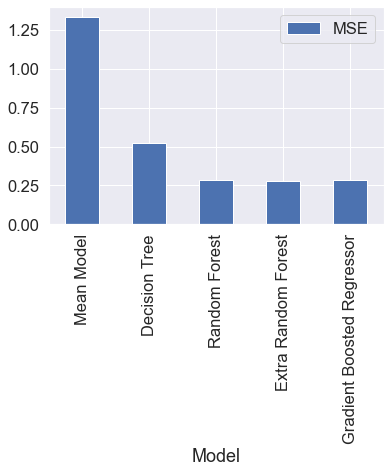

In [10]:
model_performance.append(gradient_performance).plot(x="Model", y="MSE", kind="bar");

## Determining feature importance


With a linear regression, we could inspect the coefficients to tell which terms were the most important.  With decision trees and random forests, the model structure is much more opaque.  Fortunately, all of these models (once trained) have an array called `feature_importances_` which gives the importances of all the features.  How do they compute feature importance?  According to the [Scikit documentation](http://scikit-learn.org/stable/modules/ensemble.html#feature-importance-evaluation):

> The relative rank (i.e. depth) of a feature used as a decision node in a tree can be used to assess the relative importance of that feature with respect to the predictability of the target variable. Features used at the top of the tree are used contribute to the final prediction decision of a larger fraction of the input samples. The expected fraction of the samples they contribute to can thus be used as an estimate of the relative importance of the features.

Let's show this in action.  For Scikit, larger values are more important and the values of `feature_importances_` sum to 1:

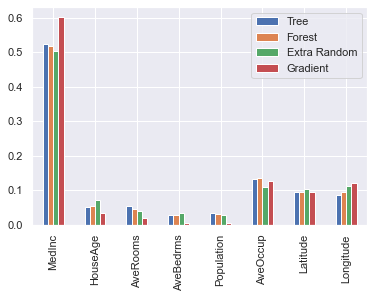

In [11]:
sns.set(font_scale=1)
columns = california.feature_names
pd.DataFrame([
    tree_reg.fit(X_cal, y_cal).feature_importances_,
    forest_reg.fit(X_cal, y_cal).feature_importances_,
    extra_reg.fit(X_cal, y_cal).feature_importances_,
    gradient_reg.fit(X_cal, y_cal).feature_importances_
], columns=columns, index=["Tree", "Forest", "Extra Random", "Gradient"]).T.plot(kind="bar").legend(loc="upper right");

### Final Questions

1. What is the tradeoff between Decision Trees, Random Forests, and Gradient Boosting Trees, in terms of explicability, computational time, memory, and accuracy?
2. What are some pros and cons of using decision trees (as opposed to other ML algorithms)?

### Exit Tickets

1. What attribute(s) of decision trees enable them to be chained together into gradient boosting trees?
1. Which is more computationally intensive? Training or testing?
1. Can a random forest model be trained online?

### Answers


#### Decision Trees

Increasing `max_features` and `max_depth` and decreasing `min_samples_split` and `min_samples_leaf` tend to build more complex models (increase Variance and reduce Bias).


#### Extremely Random Forests

The variance between different trees tends to cancel each other while the biases reinforce each other. That is, because the trees are different, they tend to overfit in different ways but when they underfit, they underfit the same way. So you want to use higher variance, lower bias parameters than you would with a decision tree.


#### Gradient Boosting Trees

Increasing the learning rate increases variance. Decreasing the fraction subsampled and the max features will decrease the variance.


#### Final Questions

1. Decision Trees are clearly the least accurate although possibly the most explicable and they train quickly.  (Extra) Random Forests are more expensive to train but can be trained in parallel -- both across processors on the same data in one machine and across machines by splitting up the sample data.  Gradient Boosting Trees are not as naturally parallelizable and (empirically) seem to be the slowest. Also see the [choosing ML algorithms notebook](AM_Choosing_ML_Algorithms.ipynb).
2. Pros and cons can be found [here](http://scikit-learn.org/stable/modules/tree.html#decision-trees).